In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn import model_selection, linear_model, metrics
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

from evaluating import evaluating

In [2]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

2024-09-25 16:41:43.486076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 16:41:43.486204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 16:41:43.619943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available: True


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 150270333796528894
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16266690560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1368341722770021620
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


# Загрузка данных

In [5]:
# запись всех названий файлов из папки data
all_files=[]
import os
for root, dirs, files in os.walk("/kaggle/input/ml-cource-cifrum-anomaly-public/data"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [6]:
# загрузка всех файлов и формирование списка из датафреймов
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

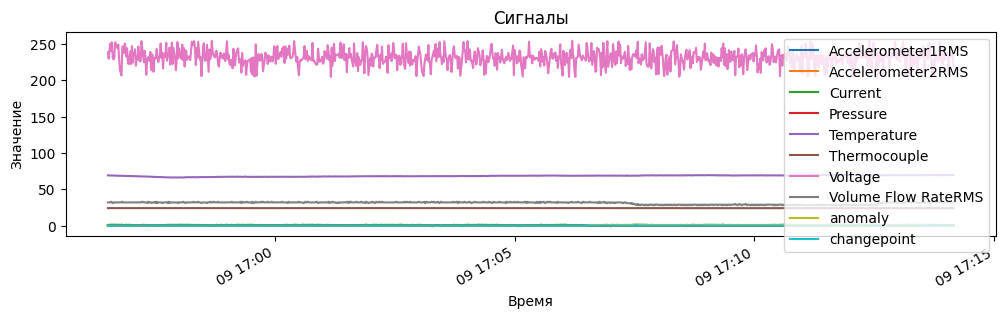

In [7]:
# Визуализация сигналов
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Сигналы')
plt.show()

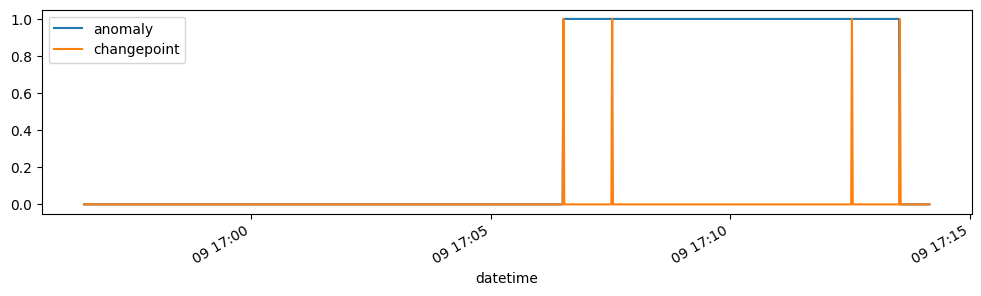

In [8]:
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

In [9]:
list_of_df[0]

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 16:16:30,0.027545,0.041127,0.673506,0.054711,67.8345,24.3164,240.513,32.0000,0.0,0.0
2020-03-09 16:16:31,0.027997,0.039100,0.772264,0.054711,67.8704,24.3279,229.523,32.0000,0.0,0.0
2020-03-09 16:16:32,0.028418,0.038872,0.675520,0.054711,67.7882,24.3261,242.708,32.0000,0.0,0.0
2020-03-09 16:16:33,0.027625,0.039366,0.566279,-0.273216,67.7918,24.3323,229.709,32.0000,0.0,0.0
2020-03-09 16:16:34,0.027484,0.041854,1.292170,0.054711,67.7368,24.3250,242.746,32.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 16:36:26,0.026954,0.040592,1.200720,0.054711,67.6181,24.2314,245.247,32.0000,0.0,0.0
2020-03-09 16:36:27,0.027371,0.040530,1.318550,-0.273216,67.8733,24.2234,243.576,32.0000,0.0,0.0
2020-03-09 16:36:28,0.027557,0.039432,1.068740,0.054711,67.6173,24.2315,239.957,31.9603,0.0,0.0


# Обучение моделей

## LSTM AE

In [9]:
from ae_lstm import LSTM_AE

### Загрузка модели,инициализация гиперпараметров и обучение

In [10]:
# Гиперпараметры модели
EPOCHS = 10
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_STEPS = 100
Q = 0.99
PARAM = [EPOCHS, BATCH_SIZE, VAL_SPLIT]

In [11]:
# функция для генерации последовательностей для обучения модели с необходимым шагом (временным лагом)
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [12]:
%%time
# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # иницаилацзия и обучение объекта класса масштабировщиков
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # масштабирование
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # обучение модели
    # history, model = arch(X)
    try:
        with tf.device("/device:GPU:0"):
            # инициализация модели
            model = LSTM_AE(PARAM)
            history = model.fit(X)

            # прогнозирование, формирование невязки модели и подбор порога
            residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
            UCL = residuals.quantile(Q) * 1.2

            # прогнозирование на тестовой выборке и формирование невязки
            X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
            residuals_test = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))

            # сравнение невязки с порогом, разметка данных на аномальный и нормальный режим работы
            anomalous_data = residuals_test > UCL
            anomalous_data_indices = []
            for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
                if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
                    anomalous_data_indices.append(data_idx)

            prediction = pd.Series(data=0, index=df.index)
            prediction.iloc[anomalous_data_indices] = 1

            # сохранение аномалий в список аномалий по каждому датасету
            predicted_outlier.append(prediction)

            # прогнозирование точек изменения состояния
            prediction_cp = abs(prediction.diff())
            prediction_cp[0] = prediction[0]
            predicted_cp.append(prediction_cp)
            
    except RuntimeError as e:
        print(e)


Epoch 1/10
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7807 - mse: 0.9861

I0000 00:00:1727276444.973852     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.7695 - mse: 0.9538 - val_loss: 0.8017 - val_mse: 1.0155
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7428 - mse: 0.9500 - val_loss: 0.7869 - val_mse: 1.0113
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7419 - mse: 0.9525 - val_loss: 0.7951 - val_mse: 1.0182
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7343 - mse: 0.9450 - val_loss: 0.8049 - val_mse: 1.0501
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7336 - mse: 0.9538 - val_loss: 0.8273 - val_mse: 1.0977
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7283 - mse: 0.9407 - val_loss: 33.3713 - val_mse: 29796.9180
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 28253.9414 - mse: 161278525440.0000 - val_loss: 0.8263 - val_mse: 1.0924
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 882ms/step - loss: 0.7406 - mse: 0.9780 - val_loss: 0.8064 - val_m

W0000 00:00:1727276807.141140     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727276807.144634     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 895ms/step - loss: 0.7677 - mse: 0.9693 - val_loss: 0.8365 - val_mse: 1.1875
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7518 - mse: 0.9621 - val_loss: 0.8203 - val_mse: 1.1387
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7485 - mse: 0.9546 - val_loss: 0.8122 - val_mse: 1.1238
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7439 - mse: 0.9566 - val_loss: 0.8112 - val_mse: 1.1138
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7407 - mse: 0.9530 - val_loss: 0.8042 - val_mse: 1.1005
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7396 - mse: 0.9455 - val_loss: 0.7997 - val_mse: 1.0876
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7397 - mse: 0.9402 - val_loss: 0.7942 - val_mse: 1.0702
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7394 - mse: 0.9311 - val_loss: 0.8003 - val_mse: 1.0829
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7413 - mse: 0.9295 

W0000 00:00:1727276834.031487     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727276834.034862     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 885ms/step - loss: 0.7728 - mse: 0.9195 - val_loss: 0.8237 - val_mse: 1.1854
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7478 - mse: 0.8889 - val_loss: 0.8200 - val_mse: 1.1875
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7445 - mse: 0.8908 - val_loss: 0.8148 - val_mse: 1.1559
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7398 - mse: 0.8861 - val_loss: 0.8283 - val_mse: 1.1815
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7339 - mse: 0.9067 - val_loss: 0.8131 - val_mse: 1.1319
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7271 - mse: 0.8762 - val_loss: 0.8320 - val_mse: 1.1572
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7355 - mse: 0.8902 - val_loss: 0.8086 - val_mse: 1.1289
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7363 - mse: 0.8720 - val_loss: 0.8094 - val_mse: 1.1567
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7308 - mse: 0.8680 

W0000 00:00:1727277141.629821     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727277141.633435     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 871ms/step - loss: 0.8041 - mse: 1.0197 - val_loss: 0.7566 - val_mse: 0.9521
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7763 - mse: 1.0205 - val_loss: 0.7328 - val_mse: 0.9347
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7783 - mse: 1.0563 - val_loss: 0.7329 - val_mse: 0.9287
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7756 - mse: 1.0501 - val_loss: 0.7310 - val_mse: 0.9266
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7748 - mse: 1.0389 - val_loss: 0.7288 - val_mse: 0.9275
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7693 - mse: 1.0509 - val_loss: 0.7284 - val_mse: 0.9212
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7679 - mse: 1.0272 - val_loss: 0.7191 - val_mse: 0.9080
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7613 - mse: 1.0311 - val_loss: 0.7050 - val_mse: 0.8787
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8074 - mse: 4.6318 

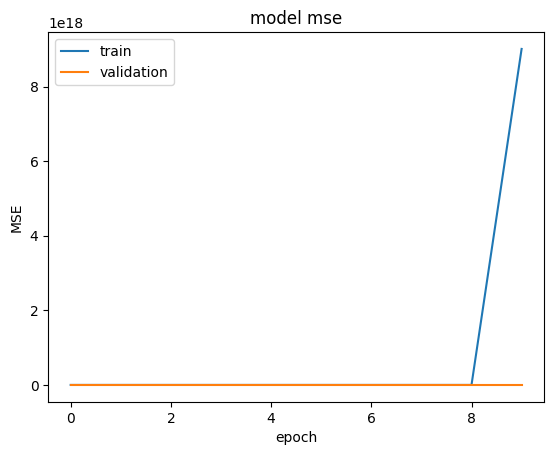

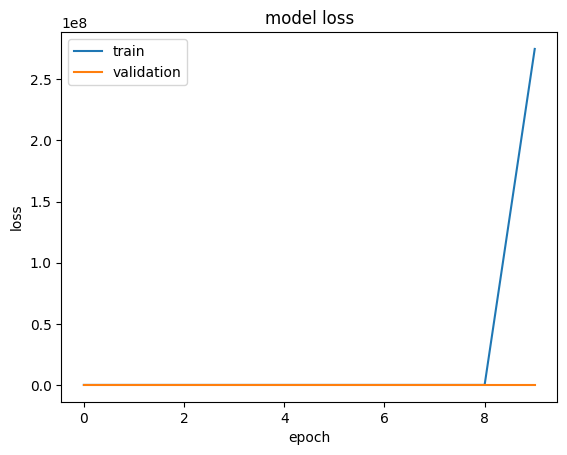

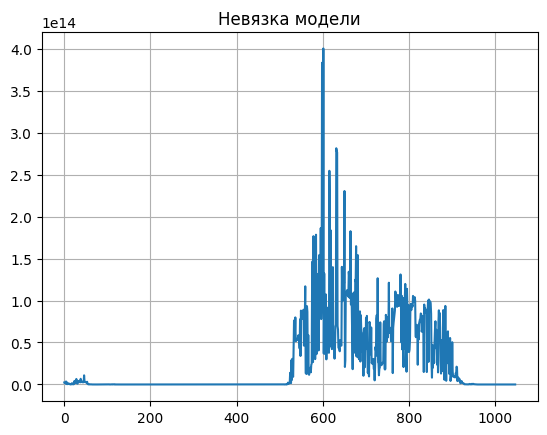

In [13]:
# "MSE"
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(residuals_test)
plt.title("Невязка модели")
plt.grid();
plt.show();

In [14]:
# формирование векторов правильных ответов
true_outlier = [df.anomaly for df in list_of_df]

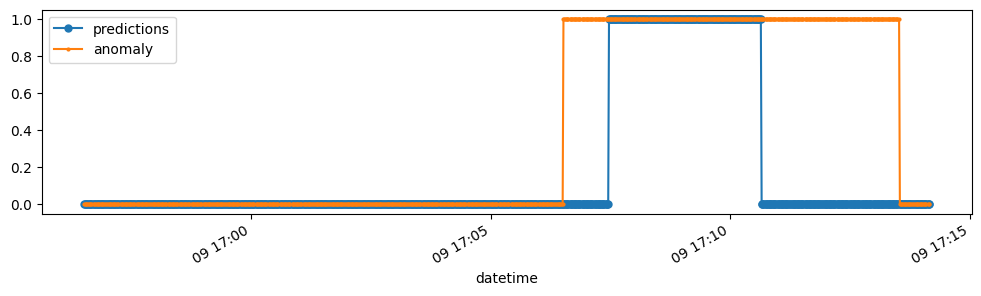

In [15]:
# визуализация 
predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

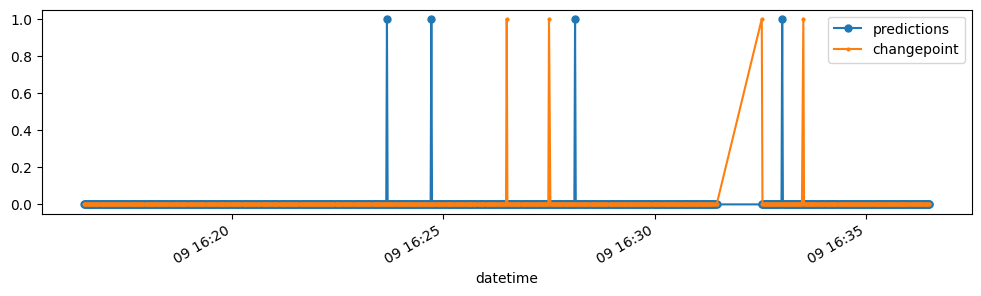

In [16]:
# формирование векторов правильных ответов
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

### Оценка точности модели

#### Метрики для задачи поиска аномалий

In [17]:
true = pd.concat(true_outlier) # вектор правильных ответов

In [18]:
pred = pd.concat(predicted_outlier) # вектор предсказаний

In [19]:
print(classification_report(true, pred)) # отчет о классификации

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     24334
         1.0       0.90      0.55      0.68     13067

    accuracy                           0.82     37401
   macro avg       0.85      0.76      0.78     37401
weighted avg       0.84      0.82      0.81     37401



In [20]:
print("F1: ", f1_score(true, pred)) # метрика f1

F1:  0.684979599582503


Выведем матрицу ошибок

<Axes: >

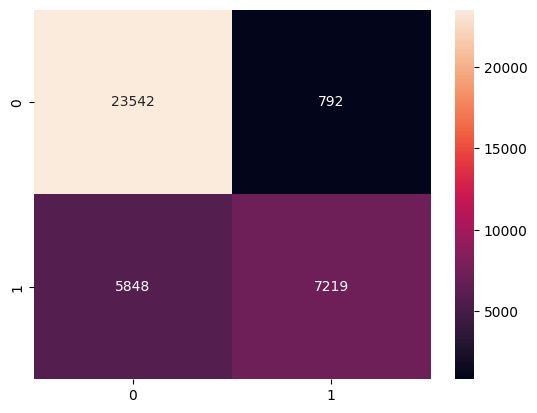

In [21]:
# построение матрицы ошибок
sns.heatmap(confusion_matrix(true,pred), annot = True, fmt = "0")

Метрики для задачи поиска точек изменения состояния

In [22]:
# расчет количества положительных и ложных срабатываний, а также среднего времени обнаружения 
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-09 16:30:30'), Timestamp('2020-03-09 16:27:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:36:32'), Timestamp('2020-03-09 16:33:31'))
Intersection of scoring windows(Timestamp('2020-03-09 17:10:02.600000'), Timestamp('2020-03-09 17:07:32'))
Intersection of scoring windows(Timestamp('2020-03-09 17:16:03.600000'), Timestamp('2020-03-09 17:13:32'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:30.800000'), Timestamp('2020-03-09 16:47:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:56:30.800000'), Timestamp('2020-03-09 16:53:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:10:29.800000'), Timestamp('2020-03-09 16:07:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:16:29.800000'), Timestamp('2020-03-09 16:13:30'))
Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:2

In [23]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-09 16:29:00'), Timestamp('2020-03-09 16:25:00'))
Intersection of scoring windows(Timestamp('2020-03-09 16:35:02'), Timestamp('2020-03-09 16:31:01'))
Intersection of scoring windows(Timestamp('2020-03-09 17:09:01'), Timestamp('2020-03-09 17:05:02'))
Intersection of scoring windows(Timestamp('2020-03-09 17:10:02'), Timestamp('2020-03-09 17:10:02'))
Intersection of scoring windows(Timestamp('2020-03-09 17:15:02'), Timestamp('2020-03-09 17:11:02'))
Intersection of scoring windows(Timestamp('2020-03-09 16:49:01'), Timestamp('2020-03-09 16:45:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:01'), Timestamp('2020-03-09 16:50:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:55:01'), Timestamp('2020-03-09 16:51:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:09:00'), Timestamp('2020-03-09 16:05:00'))
Intersection of scoring windows(Timestamp('2020-03-09 16:10:00'), Timestamp('2020-03-09 16:10:00'))


## LSTM

### Загрузка модели, инициализация гиперпараметров и обучение

In [24]:
from nn_lstm import Simple_LSTM

In [25]:
# гиперпараметры модели
N_STEPS = 5
EPOCHS = 10
BATCH_SIZE = 32
VAL_SPLIT = 0.2
PARAMS = [N_STEPS, EPOCHS, BATCH_SIZE, VAL_SPLIT]
Q = 0.99

In [26]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [27]:
%%time
# инференс
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # обучение нормализатора данных
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    try:
        with tf.device("/device:GPU:0"):
            # инициализация модели
            model = Simple_LSTM(PARAMS)

            # обучение модели
            history = model.fit(X, y)

            # прогнозирование на обучающей выборке
            residuals_train = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
            UCL = residuals_train.quantile(Q) * 1.2

            # прогноз на всей выборке
            X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
            lstm_residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
            prediction = pd.Series((lstm_residuals > UCL).astype(int).values, 
                                        index=df[N_STEPS:].index).fillna(0)

            # сохранение предсказаний для задачи поиска аномалий
            predicted_outlier.append(prediction)

            # сохранение предсказаний для задачи поиска точек изменения состояния
            prediction_cp = abs(prediction.diff())
            prediction_cp[0] = prediction[0]
            predicted_cp.append(prediction_cp)
        
                
    except RuntimeError as e:
        print(e)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 548ms/step - loss: 0.8265 - mse: 1.0902 - val_loss: 0.8261 - val_mse: 1.0960 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8194 - mse: 1.0836 - val_loss: 0.8231 - val_mse: 1.0963 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8130 - mse: 1.0786 - val_loss: 0.8175 - val_mse: 1.0970 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7952 - mse: 1.0731 - val_loss: 0.8136 - val_mse: 1.1141 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8038 - mse: 1.1024 - val_loss: 0.8116 - val_mse: 1.0879 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7823 - mse: 1.0458 - val_loss: 0.8070 - val_mse: 1.0774 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7649 - mse: 1.0193 - val_loss: 0.7979 - val_mse: 1.0438 - learning_rate: 0.0010
Epoch 8/10
10/10 

W0000 00:00:1727277827.798258     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727277827.798718     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727277827.799121     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727277827.799511     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


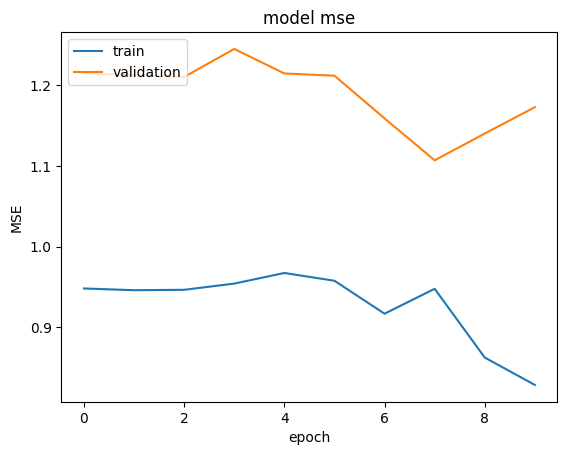

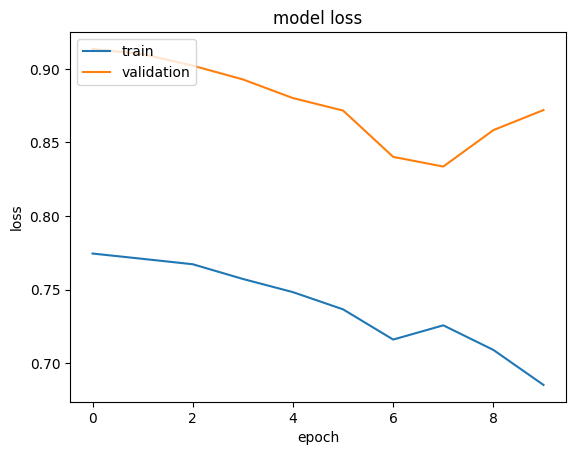

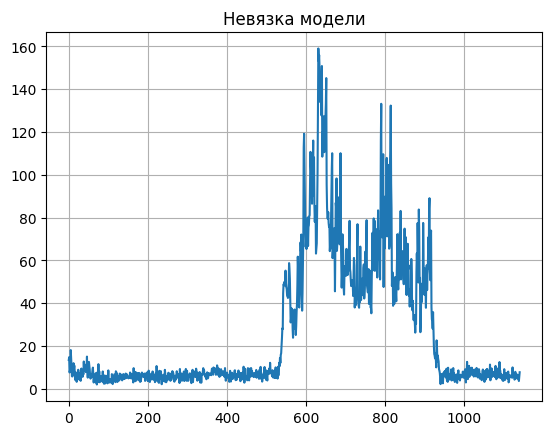

In [28]:
# "MSE"
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(lstm_residuals)
plt.title("Невязка модели")
plt.grid();
plt.show();

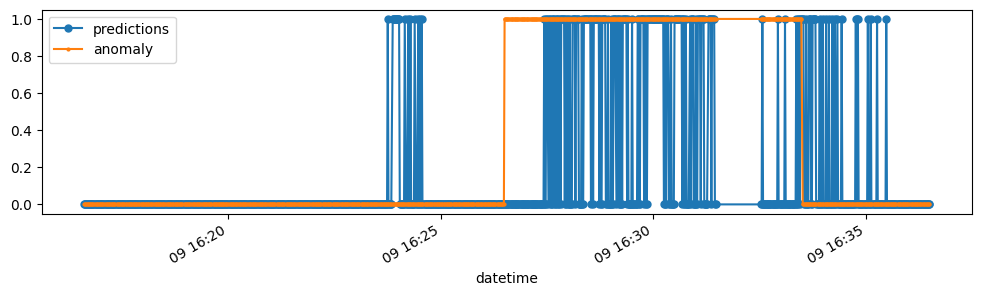

In [29]:
# формирование векторов правильных ответов
true_outlier = [df.anomaly[N_STEPS:] for df in list_of_df]

# построение графиков
predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

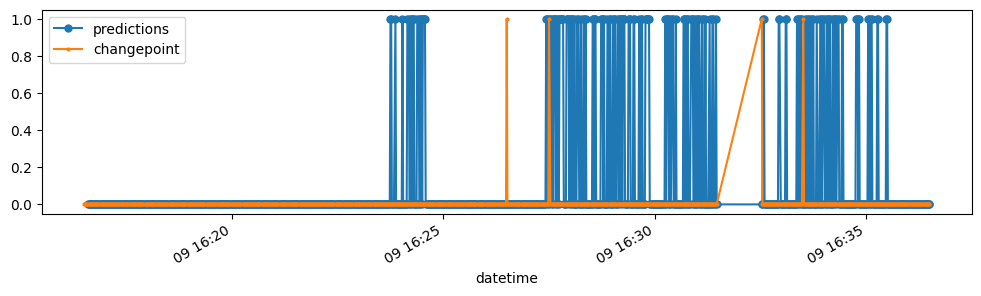

In [30]:
# формирование векторов правильных ответов
true_cp = [df.changepoint for df in list_of_df]

# построение графиков
predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

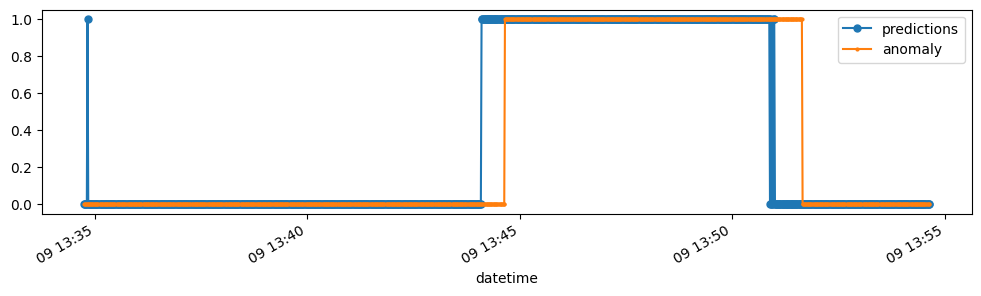

In [31]:
predicted_outlier[-1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[-1].plot(marker='o', markersize=2)
plt.legend();

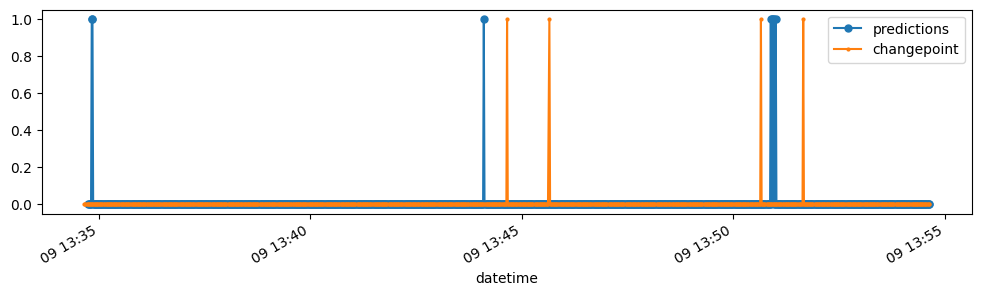

In [32]:
predicted_cp[-1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[-1].plot(marker='o', markersize=2)
plt.legend();

### Оценка точности модели

#### Метрики для задачи поиска аномалий

In [33]:
true = pd.concat(true_outlier)
pred = pd.concat(predicted_outlier)

In [34]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85     24164
         1.0       0.76      0.63      0.69     13067

    accuracy                           0.80     37231
   macro avg       0.79      0.76      0.77     37231
weighted avg       0.80      0.80      0.80     37231



In [35]:
print("F1: ", f1_score(true, pred))

F1:  0.6905717151454362


<Axes: >

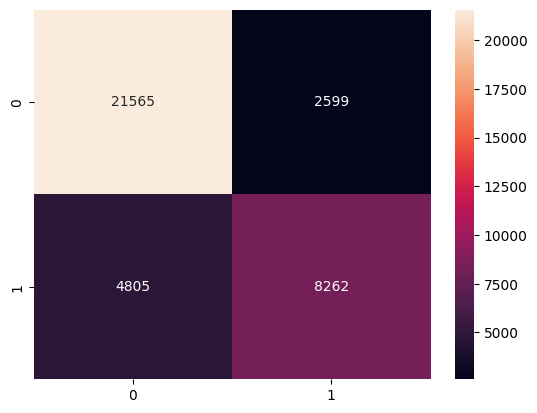

In [36]:
# матрица ошибок
sns.heatmap(confusion_matrix(true,pred), annot = True, fmt = "0")

Метрики для задачи поиска точек изменения состояния

In [37]:
# расчет количества положительных и ложных срабатываний, а также среднего времени обнаружения 
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-09 16:30:28.800000'), Timestamp('2020-03-09 16:27:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:36:30.800000'), Timestamp('2020-03-09 16:33:31'))
Intersection of scoring windows(Timestamp('2020-03-09 17:10:01.600000'), Timestamp('2020-03-09 17:07:32'))
Intersection of scoring windows(Timestamp('2020-03-09 17:16:02.600000'), Timestamp('2020-03-09 17:13:32'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:29.600000'), Timestamp('2020-03-09 16:47:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:56:29.600000'), Timestamp('2020-03-09 16:53:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:10:28.800000'), Timestamp('2020-03-09 16:07:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:16:28.800000'), Timestamp('2020-03-09 16:13:30'))
Intersection of scoring windows(Timestamp('2020-03-01 15:58:08.333333333'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Ti

In [38]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-09 16:29:00'), Timestamp('2020-03-09 16:25:00'))
Intersection of scoring windows(Timestamp('2020-03-09 16:35:02'), Timestamp('2020-03-09 16:31:01'))
Intersection of scoring windows(Timestamp('2020-03-09 17:09:01'), Timestamp('2020-03-09 17:05:02'))
Intersection of scoring windows(Timestamp('2020-03-09 17:10:02'), Timestamp('2020-03-09 17:10:02'))
Intersection of scoring windows(Timestamp('2020-03-09 17:15:02'), Timestamp('2020-03-09 17:11:02'))
Intersection of scoring windows(Timestamp('2020-03-09 16:49:01'), Timestamp('2020-03-09 16:45:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:01'), Timestamp('2020-03-09 16:50:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:55:01'), Timestamp('2020-03-09 16:51:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:09:00'), Timestamp('2020-03-09 16:05:00'))
Intersection of scoring windows(Timestamp('2020-03-09 16:10:00'), Timestamp('2020-03-09 16:10:00'))


## Conv AE

In [10]:
for n in range(len(list_of_df)):
    df = list_of_df[n]
    for col in df.columns:
        df[df < 0] = 0
    list_of_df[n] = df 

In [11]:
pd.concat(list_of_df)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 16:16:30,0.027545,0.041127,0.673506,0.054711,67.8345,24.3164,240.513,32.0,0.0,0.0
2020-03-09 16:16:31,0.027997,0.039100,0.772264,0.054711,67.8704,24.3279,229.523,32.0,0.0,0.0
2020-03-09 16:16:32,0.028418,0.038872,0.675520,0.054711,67.7882,24.3261,242.708,32.0,0.0,0.0
2020-03-09 16:16:33,0.027625,0.039366,0.566279,0.000000,67.7918,24.3323,229.709,32.0,0.0,0.0
2020-03-09 16:16:34,0.027484,0.041854,1.292170,0.054711,67.7368,24.3250,242.746,32.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-03-09 13:54:33,0.028018,0.040727,1.369300,0.054711,68.7040,24.7300,242.788,32.0,0.0,0.0
2020-03-09 13:54:35,0.027752,0.039358,0.428044,0.054711,68.6313,24.7181,203.518,32.0,0.0,0.0
2020-03-09 13:54:36,0.027357,0.039933,0.685891,0.382638,68.7858,24.7210,231.376,32.0,0.0,0.0


In [12]:
for ind in range(len(list_of_df)):
    # признаки, имеющие физический смысл
    # мощность
    list_of_df[ind]["Power"] = list_of_df[ind]["Current"] * list_of_df[ind]["Voltage"] 
    # отношение расхода к мощности
    list_of_df[ind]["Power_flow_rate"] = list_of_df[ind]["Volume Flow RateRMS"] / list_of_df[ind]["Power"]
    # разница температур (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Temperature_diff"] = list_of_df[ind]['Temperature'] - list_of_df[ind]['Thermocouple'] 
    # разница акселлерометров (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Accel_diff"] = list_of_df[ind]['Accelerometer1RMS'] - list_of_df[ind]['Accelerometer2RMS']
    
    # сглаживания
    list_of_df[ind]["Volume Flow RateRMS_10mean"] = list_of_df[ind]["Volume Flow RateRMS"].rolling(window = 10, min_periods=0).mean()

In [13]:
list_of_df = list_of_df(['Thermocouple', 'Accelerometer2RMS'], axis=1)

TypeError: 'list' object is not callable

### Инициализация модели, гиперпараметров и ее обучение

In [14]:
from cnn_ae import Conv_AE

In [15]:
EPOCHS = 10
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_STEPS = 60
Q = 0.999

In [16]:
#гиперпараметры модели
N_STEPS = 60
Q = 0.999

In [17]:
# функция для генерации выборок для обучения
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [18]:
%%time
# инференс
predicted_outlier, predicted_cp = [], []
with tf.device("/device:GPU:0"):
    for df in list_of_df:
        X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)

        # инициализация и обучение нормализатора данных
        StSc = StandardScaler()
        StSc.fit(X_train)

        # масштабирование данных и генерация выборок для обучения
        X = create_sequences(StSc.transform(X_train), N_STEPS)

        # инициализация модели
        model = Conv_AE()
        # обучение модели
        model.fit(X)

        # прогноз на обучающей выборке и выбор порога
        residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
        UCL = residuals.quantile(Q) * 1.1

        # прогноз на всей выборке и поиск аномалий по порогу
        X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
        cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
        
        anomalous_data = cnn_residuals > UCL
        anomalous_data_indices = []
        for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
            if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx)

        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1

        # сохранение результатов предсказания аномалий
        predicted_outlier.append(prediction)

        # сохранение предсказания точек изменения состояния
        prediction_cp = abs(prediction.diff())
        prediction_cp[0] = prediction[0]
        predicted_cp.append(prediction_cp)

I0000 00:00:1727282646.086262     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
34/3

In [19]:
# "MSE"
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(cnn_residuals)
plt.title("Невязка модели")
plt.grid();
plt.show();

NameError: name 'history' is not defined

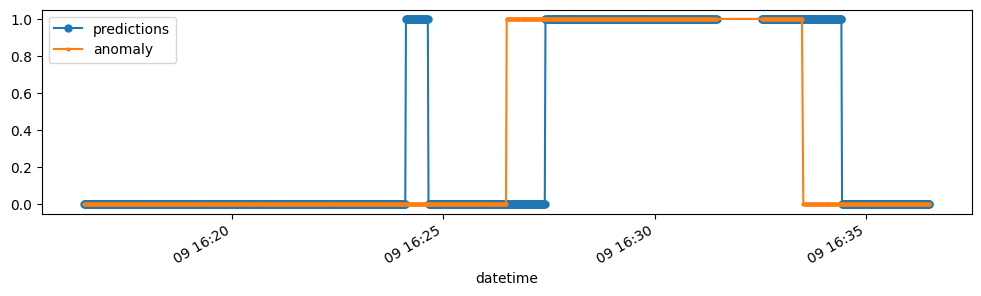

In [20]:
# формирование векторов правильных ответов
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

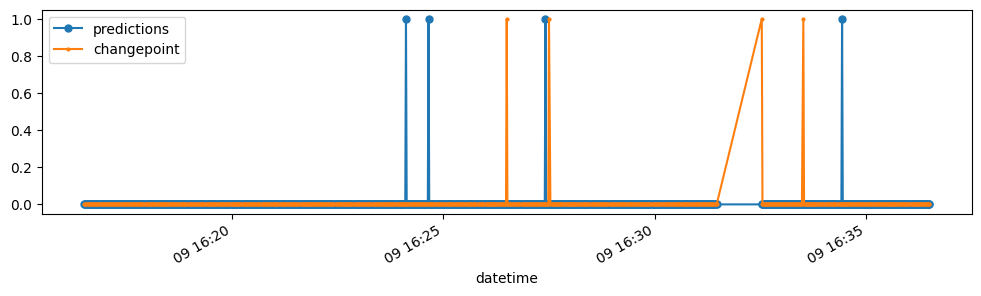

In [21]:
# формирование векторов правильных ответов
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

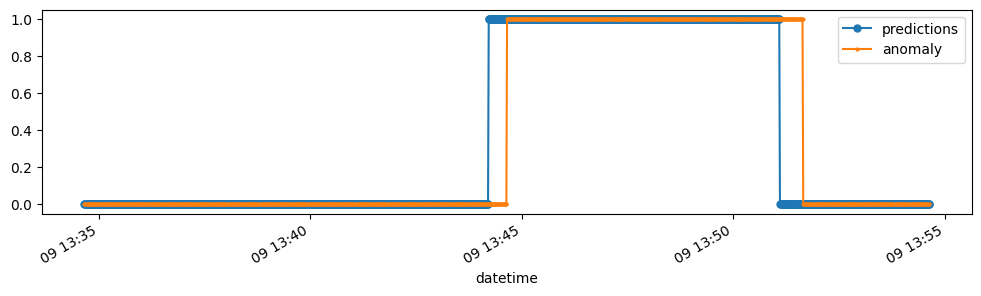

In [22]:
predicted_outlier[-1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[-1].plot(marker='o', markersize=2)
plt.legend();

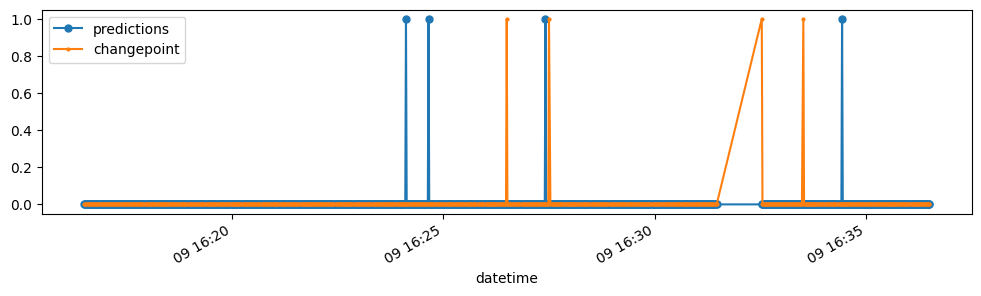

In [23]:
predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

### Оценка точности модели

#### Метрики для задачи поиска аномалий

In [24]:
true = pd.concat(true_outlier)
pred = pd.concat(predicted_outlier)

In [25]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92     24334
         1.0       0.83      0.86      0.85     13067

    accuracy                           0.89     37401
   macro avg       0.88      0.88      0.88     37401
weighted avg       0.89      0.89      0.89     37401



In [26]:
print("F1: ", f1_score(true, pred))

F1:  0.8455818518099121


<Axes: >

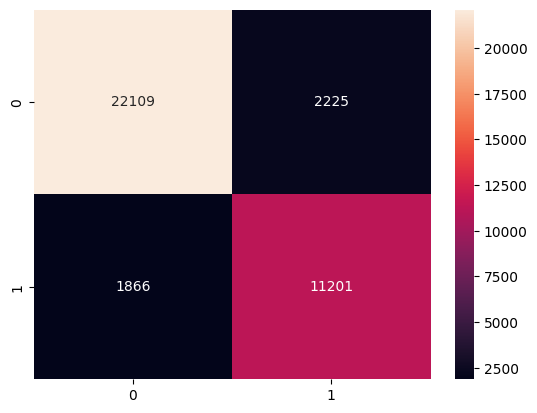

In [27]:
sns.heatmap(confusion_matrix(true,pred), annot = True, fmt = "0")

Метрики для задачи поиска точек изменения состояния

In [28]:
# расчет количества положительных и ложных срабатываний, а также среднего времени обнаружения 
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-09 16:30:30'), Timestamp('2020-03-09 16:27:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:36:32'), Timestamp('2020-03-09 16:33:31'))
Intersection of scoring windows(Timestamp('2020-03-09 17:10:02.600000'), Timestamp('2020-03-09 17:07:32'))
Intersection of scoring windows(Timestamp('2020-03-09 17:16:03.600000'), Timestamp('2020-03-09 17:13:32'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:30.800000'), Timestamp('2020-03-09 16:47:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:56:30.800000'), Timestamp('2020-03-09 16:53:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:10:29.800000'), Timestamp('2020-03-09 16:07:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:16:29.800000'), Timestamp('2020-03-09 16:13:30'))
Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:2

In [29]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-03-09 16:29:00'), Timestamp('2020-03-09 16:25:00'))
Intersection of scoring windows(Timestamp('2020-03-09 16:35:02'), Timestamp('2020-03-09 16:31:01'))
Intersection of scoring windows(Timestamp('2020-03-09 17:09:01'), Timestamp('2020-03-09 17:05:02'))
Intersection of scoring windows(Timestamp('2020-03-09 17:10:02'), Timestamp('2020-03-09 17:10:02'))
Intersection of scoring windows(Timestamp('2020-03-09 17:15:02'), Timestamp('2020-03-09 17:11:02'))
Intersection of scoring windows(Timestamp('2020-03-09 16:49:01'), Timestamp('2020-03-09 16:45:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:01'), Timestamp('2020-03-09 16:50:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:55:01'), Timestamp('2020-03-09 16:51:01'))
Intersection of scoring windows(Timestamp('2020-03-09 16:09:00'), Timestamp('2020-03-09 16:05:00'))
Intersection of scoring windows(Timestamp('2020-03-09 16:10:00'), Timestamp('2020-03-09 16:10:00'))


## AE

### Инициализация модели, гиперпараметров и ее обучение

In [30]:
from nn_ae import Simple_AE

In [31]:
# гиперпараметры модели
BEST_PARAMS = [5, 4, 2, 0.005, 32]
Q = 0.99

### Обучение модели

In [32]:
%%time
# инференс
predicted_outlier, predicted_cp = [], []
with tf.device("/device:GPU:0"):
    for df in list_of_df:
        X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)

        # scaler init and fitting
        StSc = StandardScaler()
        StSc.fit(X_train)

        
        # инициализация модели
        model = Simple_AE(BEST_PARAMS)
        
        # model fitting
        model.fit(StSc.transform(X_train))

        # results predicting
        residuals_train = pd.DataFrame(StSc.transform(X_train) - \
                                       model.predict(StSc.transform(X_train))).abs().sum(axis=1)
        UCL = residuals_train.quantile(Q) * 1.2

        df_sc = StSc.transform(df.drop(['anomaly','changepoint'], axis=1))
        residuals_full_df = df_sc - model.predict(df_sc)
        residuals_full_df = pd.DataFrame(residuals_full_df).abs().sum(axis=1)

        prediction = pd.Series((residuals_full_df > UCL).astype(int).values, 
                               index=df.index).fillna(0)

        # predicted outliers saving
        predicted_outlier.append(prediction)

        # predicted CPs saving
        prediction_cp = abs(prediction.diff())
        prediction_cp[0] = prediction[0]
        predicted_cp.append(prediction_cp)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.8798 - mse: 1.1952 - val_loss: 0.8440 - val_mse: 1.1437
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8092 - mse: 1.0341 - val_loss: 0.8295 - val_mse: 1.1105
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7735 - mse: 0.9567 - val_loss: 0.8203 - val_mse: 1.0945
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7493 - mse: 0.9169 - val_loss: 0.8151 - val_mse: 1.0900
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7324 - mse: 0.8965 - val_loss: 0.8101 - val_mse: 1.0858
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7205 - mse: 0.8851 - val_loss: 0.8064 - val_mse: 1.0854
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7110 - mse: 0.8763 - val_loss: 0.8040 - val_mse: 1.0854
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7030 - mse: 0.8679 - val_loss: 0.8016 - val_mse: 1.0853
Epoch 9/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6942 - mse

In [34]:
# "MSE"
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(residuals_full_df)
plt.title("Невязка модели")
plt.grid();
plt.show();

NameError: name 'history' is not defined

In [35]:
# формирование векторов правильных ответов
true_outlier = [df.anomaly for df in list_of_df]

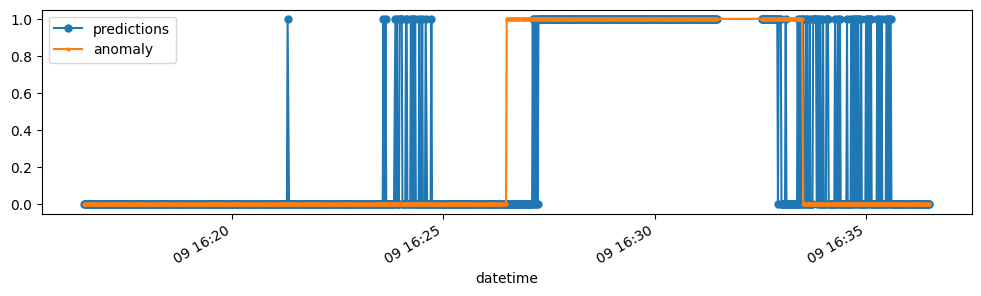

In [36]:
predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

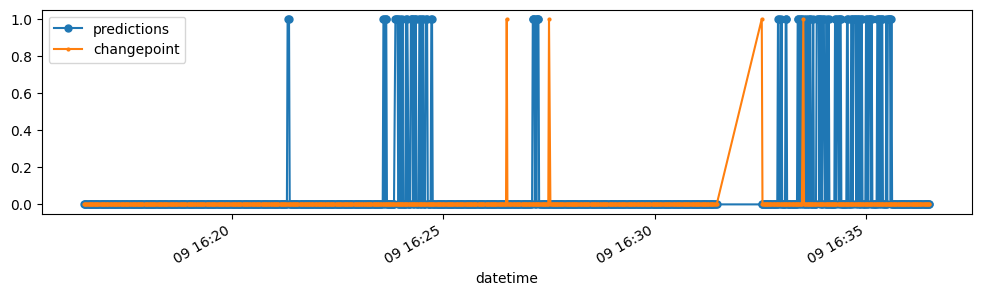

In [37]:
# формирование векторов правильных ответов
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

### Оценка точности модели

#### Метрики для задачи поиска аномалий

In [38]:
true = pd.concat(true_outlier)
pred = pd.concat(predicted_outlier)

In [39]:
pred = pd.concat(predicted_outlier)

In [40]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88     24334
         1.0       0.82      0.72      0.76     13067

    accuracy                           0.85     37401
   macro avg       0.84      0.82      0.82     37401
weighted avg       0.84      0.85      0.84     37401



In [41]:
print("F1: ", f1_score(true, pred))

F1:  0.7648805891207943


<Axes: >

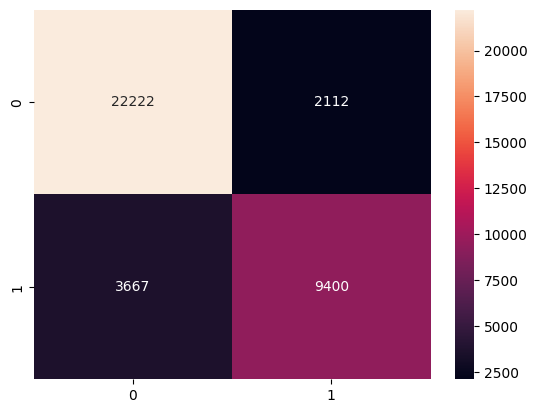

In [42]:
sns.heatmap(confusion_matrix(true,pred), annot = True, fmt = "0")

#### Метрики для задачи обнаружения точек изменения состояния (Changepoints)

In [ ]:
# расчет количества положительных и ложных срабатываний, а также среднего времени обнаружения 
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

In [ ]:
# расчет метрики nab 
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='5m',
   anomaly_window_destenation='center', 
)

## Вывод по результатам моделирования

Лучшая модель Conv_AE

Точность работы

# Прогноз на тестовой выборке и формирование предсказания

In [ ]:
import pickle

In [ ]:
from cnn_ae import Conv_AE

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, Dropout, Conv1DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.models import load_model, save_model

import tensorflow as tf
import os
import random
import numpy as np


class Conv_AE_5: 
    """
    A reconstruction convolutional autoencoder model to detect anomalies in timeseries data using reconstruction error as an anomaly score.

    Parameters
    ----------
    No parameters are required for initializing the class.

    Attributes
    ----------
    model : Sequential
        The trained convolutional autoencoder model.

    Examples
    --------
    >>> CAutoencoder = Conv_AE()
    >>> CAutoencoder.fit(train_data)
    >>> prediction = CAutoencoder.predict(test_data)
    """
    
    def __init__(self):
        self._Random(0)
        
    def _Random(self, seed_value): 

       
        os.environ['PYTHONHASHSEED'] = str(seed_value)

        
        random.seed(seed_value)

        
        np.random.seed(seed_value)

        
        tf.random.set_seed(seed_value)
        
    def _build_model(self):
        
        model = Sequential(
            [
                Input(shape=(self.shape[1], self.shape[2])),
                Conv1D(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Dropout(rate=0.2),
                Conv1D(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Conv1DTranspose(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Dropout(rate=0.2),
                Conv1DTranspose(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
            ]
        )
        model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
        
        return model
    
    def fit(self, data, validation_split=0.1, epochs=40, verbose=0, shuffle=True, batch_size = 32):
        """
        Train the convolutional autoencoder model on the provided data.

        Parameters
        ----------
        data : numpy.ndarray
            Input data for training the autoencoder model.
        """
        
        self.shape = data.shape
        self.model = self._build_model()
        
        history = History()
        
        return self.model.fit(
            data,
            data,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=verbose,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0),history
            ],
        )

    def predict(self, data):
        """
        Generate predictions using the trained convolutional autoencoder model.

        Parameters
        ----------
        data : numpy.ndarray
            Input data for generating predictions.

        Returns
        -------
        numpy.ndarray
            Predicted output data.
        """
        
        return self.model.predict(data)

In [ ]:
class Conv_AE_6:     
    def __init__(self):
        self._Random(0)
        
    def _Random(self, seed_value):      
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        
    def _build_model(self):
        
        model = Sequential(
            [
                Input(shape=(self.shape[1], self.shape[2])),
                Conv1D(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Dropout(rate=0.2),
                Conv1D(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Dropout(rate=0.2),
                Conv1D(
                    filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
                ),
                Conv1DTranspose(
                    filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
                ),
                Dropout(rate=0.2),
                Conv1DTranspose(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Conv1DTranspose(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
            ]
        )
        model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
        
        return model
    
    def fit(self, data, validation_split=0.1, epochs=40, verbose=0, shuffle=True, batch_size = 32):      
        self.shape = data.shape
        self.model = self._build_model()
        
        history = History()
        
        return self.model.fit(
            data,
            data,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=verbose,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0),history
            ],
        )

    def predict(self, data):       
        return self.model.predict(data)

In [ ]:
# Test 12
from tensorflow.keras.layers import Input, Conv1D, Dropout, Conv1DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.models import load_model, save_model

import tensorflow as tf
import os
import random
import numpy as np

from tensorflow.keras.layers import BatchNormalization

In [ ]:
# Test 12
class Conv_AE_12:     
    def __init__(self):
        self._Random(0)
        
    def _Random(self, seed_value):      
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        
    def _build_model(self):
        
        model = Sequential(
            [
                Input(shape=(self.shape[1], self.shape[2])),
                Conv1D(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                BatchNormalization(),
                # Dropout(rate=0.2),
                Conv1D(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Dropout(rate=0.2),
                Conv1D(
                    filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
                ),
                Conv1DTranspose(
                    filters=8, kernel_size=7, padding="same", strides=1, activation="relu"
                ),
                Dropout(rate=0.2),
                Conv1DTranspose(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Conv1DTranspose(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
            ]
        )
        model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
        
        return model
    
    def fit(self, data, validation_split=0.1, epochs=40, verbose=0, shuffle=True, batch_size = 32):      
        self.shape = data.shape
        self.model = self._build_model()
        
        history = History()
        
        return self.model.fit(
            data,
            data,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=verbose,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0),history
            ],
        )

    def predict(self, data):       
        return self.model.predict(data)

In [ ]:
#гиперпараметры модели
# Test 12
N_STEPS = 60
Q = 0.999

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_STEPS = 60
Q = 0.999

In [ ]:
# загрузка тестовой выборки
with open("/kaggle/input/ml-cource-cifrum-anomaly-public/test.pkl", "rb") as f:
    list_of_df = pickle.load(f)


In [ ]:
list_of_df[0].head()

In [ ]:
# функция для генерации выборок для обучения
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
# Test 12
for ind in range(len(list_of_df)):
    # признаки, имеющие физический смысл
    # мощность
    list_of_df[ind]["Power"] = list_of_df[ind]["Current"] * list_of_df[ind]["Voltage"] 
    # отношение расхода к мощности
    list_of_df[ind]["Power_flow_rate"] = list_of_df[ind]["Volume Flow RateRMS"] / list_of_df[ind]["Power"]
    # разница температур (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Temperature_diff"] = list_of_df[ind]['Temperature'] - list_of_df[ind]['Thermocouple'] 
    # разница акселлерометров (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Accel_diff"] = list_of_df[ind]['Accelerometer1RMS'] - list_of_df[ind]['Accelerometer2RMS']
       
    # сглаживания
    list_of_df[ind]["Volume Flow RateRMS_10mean"] = list_of_df[ind]["Volume Flow RateRMS"].rolling(window = 10, min_periods=0).mean()
   

In [ ]:
for ind in range(len(list_of_df)):
    # признаки, имеющие физический смысл
    # мощность
    list_of_df[ind]["Power"] = list_of_df[ind]["Current"] * list_of_df[ind]["Voltage"] 
    # отношение расхода к мощности
    list_of_df[ind]["Power_flow_rate"] = list_of_df[ind]["Volume Flow RateRMS"] / list_of_df[ind]["Power"]
    # разница температур (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Temperature_diff"] = list_of_df[ind]['Temperature'] - list_of_df[ind]['Thermocouple'] 
    list_of_df[ind]["Temperature_mean"] = list_of_df[ind]['Temperature'] + list_of_df[ind]['Thermocouple'] 
    # разница акселлерометров (если признаки скоррелированы и с одним из них что-то происходит, то покажет наличие аномалии)
    list_of_df[ind]["Accel_diff"] = list_of_df[ind]['Accelerometer1RMS'] - list_of_df[ind]['Accelerometer2RMS']
    list_of_df[ind]["Accel_mean"] = list_of_df[ind]['Accelerometer1RMS'] + list_of_df[ind]['Accelerometer2RMS']
    
    # сглаживания
    list_of_df[ind]["Volume Flow RateRMS_10mean"] = list_of_df[ind]["Volume Flow RateRMS"].rolling(window = 10, min_periods=0).mean()
    
    # list_of_df[ind] = list_of_df[ind].drop(['Thermocouple', 'Accelerometer2RMS'], axis=1)
    out_std = list_of_df[ind].std()
    out_mean = list_of_df[ind].mean()
    list_of_df[ind] = (list_of_df[ind] - out_mean) / out_std 

In [ ]:
%%time
# инференс
predicted_outlier, predicted_cp = [], []
with tf.device("/device:GPU:0"):
    for df in list_of_df:
        X_train = df[:400]

        # инициализация и обучение нормализатора данных
        StSc = StandardScaler()
        StSc.fit(X_train)

        # масштабирование данных и генерация выборок для обучения
        X = create_sequences(StSc.transform(X_train), N_STEPS)

        # инициализация модели
        # model = Conv_AE_6()
        model = Conv_AE_12()
        # обучение модели
        model.fit(X)

        # прогноз на обучающей выборке и выбор порога
        residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
        # UCL = residuals.quantile(Q) * 1.1 # test 6
        # UCL = residuals.quantile(Q) # test 7
        # UCL = residuals.quantile(Q) * 0.9 # test 8
        # UCL = residuals.quantile(Q) * 1.2 # test 9
        UCL = residuals.quantile(Q) * 1.15 # test 10, 12

        # прогноз на всей выборке и поиск аномалий по порогу
        X = create_sequences(StSc.transform(df), N_STEPS)
        cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
        
        anomalous_data = cnn_residuals > UCL
        anomalous_data_indices = []
        for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
            if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx)

        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1

        # сохранение результатов предсказания аномалий
        predicted_outlier.append(prediction)

        # сохранение предсказания точек изменения состояния
        prediction_cp = abs(prediction.diff())
        prediction_cp[0] = prediction[0]
        predicted_cp.append(prediction_cp)

In [ ]:
# формирование вектора предсказаний по всем экспериментам
pred = pd.concat(predicted_outlier)

In [ ]:
pred

In [ ]:
y_pred=pd.Series(pred, name = "anomaly")
y_pred.index = np.arange(0, y_pred.shape[0])

y_pred = y_pred.reset_index()
y_pred.columns = ["ID", "anomaly"]
y_pred.to_csv("predict.csv", index = False)

In [ ]:
y_pred["anomaly"].value_counts()

# Инференс для лучшей модели на примере одного датасета (для веб-приложения)

In [ ]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn import model_selection, linear_model, metrics
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

## Выбор 1 эксперимента

In [ ]:
df = pd.read_csv('/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/1.csv', sep = ";", index_col='datetime', parse_dates=True)

In [ ]:
df = df.drop(['anomaly', 'changepoint'], axis=1)

In [ ]:
df

## Обучение модели

In [ ]:
#гиперпараметры модели
N_STEPS = 60
Q = 0.999

In [ ]:
import numpy as np
import random
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix



In [ ]:
# функция для генерации выборок для обучения
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [ ]:
# from cnn_ae import Conv_AE
# load model = Conv_AE_12() ! for test 12

In [ ]:
%%time
# обучающая выборка с нормальным режимом работы
X_train = df[:400]

# масштабирование данных и формирование выборок для обучения
StSc = StandardScaler()
StSc.fit(X_train)
X = create_sequences(StSc.transform(X_train), N_STEPS)

# инициализация модели
# model = Conv_AE()
model = Conv_AE_12() # Test 12
# обучение модели
model.fit(X)

In [ ]:
# построение невязки модели и подбор порога на обучающей выборке
residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
UCL = residuals.quantile(Q) * 1.1

In [ ]:
UCL

Сохранение масштабировщика

In [ ]:
import joblib

In [ ]:
joblib.dump(StSc, "stsc.pkl")

## Сохранение модели

In [ ]:
import joblib

In [ ]:
joblib.dump(model, "model.pkl")

## Загрузка модели и вывод предсказания

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import joblib

In [ ]:
load_model = joblib.load("model.pkl")

In [ ]:
load_model

## Загрузка файла с 1 эскпериментом

In [ ]:
df = pd.read_csv('/kaggle/input/ml-cource-cifrum-anomaly-public/data/other/1.csv', sep = ";", index_col='datetime', parse_dates=True)
df = df.drop(['anomaly', 'changepoint'], axis=1)

## Инференс модели

In [ ]:
# прогноз на всей выборке и построение невязки
X = create_sequences(StSc.transform(df), N_STEPS)
cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - load_model.predict(X)), axis=1), axis=1))

# выделение аномалий и разметка на нормальный и аномальный режимы
anomalous_data = cnn_residuals > UCL
anomalous_data_indices = []
for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
    if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1

# обнаружение точек изменения состояния
prediction_cp = abs(prediction.diff())
prediction_cp[0] = prediction[0]

## Вывод результатов

In [ ]:
prediction

In [ ]:
prediction.value_counts()

In [ ]:
prediction_cp